**Image2Image Pipeline for Stable Diffusion using Gradio**

In [1]:
!nvidia-smi

Tue Oct 31 10:46:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:62:00.0 Off |                    0 |
| N/A   61C    P0              72W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -qq -U transformers ftfy gradio diffusers

In [3]:
!pip install -qq "ipywidgets>=7,<8"

In [ ]:
# pip install diffusers

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

2023-10-31 10:47:03.704849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 10:47:04.739345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
  'CompVis/stable-diffusion-v1-4',
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)
pipe = pipe

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/opt/jupyterhub/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


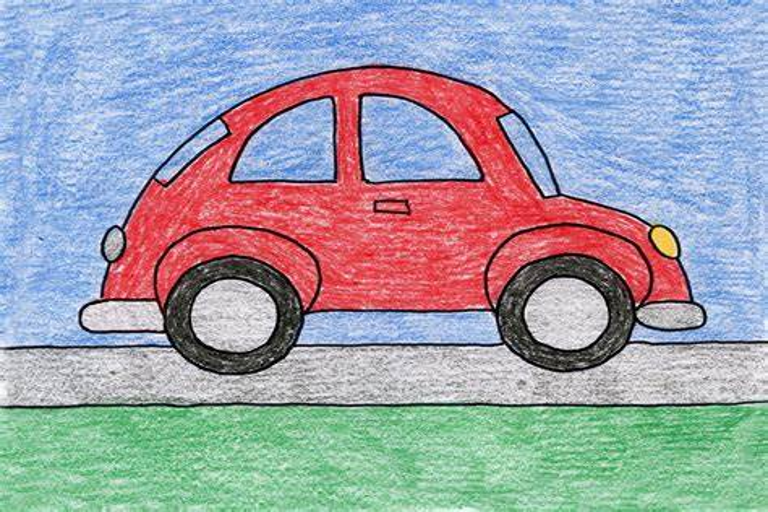

In [7]:
import requests
from io import BytesIO
from PIL import Image

url = "https://th.bing.com/th/id/OIP.ohGkZC2yTgsR4wv6GNnADAHaFu?pid=ImgDet&rs=1"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [8]:
#Define the prompt
prompt = "the offroad racing car"

In [9]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, image=init_img, strength=0.6, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

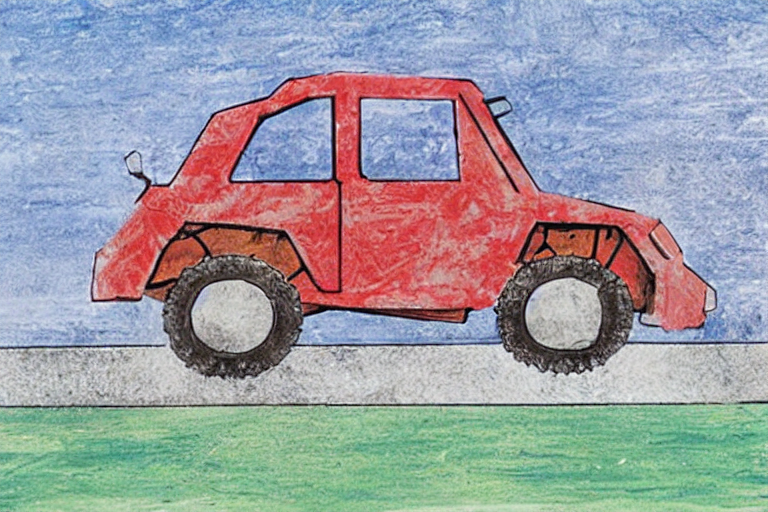

In [10]:
image

**Import Gradio library and required dependencies**

In [11]:
# pip install gradio

In [12]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as PILImage

**Define a folder to save the sketches**

In [13]:
save_folder = "/home/ochirpurev/sketches"  # Use an accessible directory in Colab
!mkdir -p $save_folder

**Define a prompt here**

In [100]:
prompt="the house in a countryside"

In [106]:
def upload_image(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    # extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.5, guidance_scale=7.5, generator=generator).images[0]
    return return_image

In [107]:
def save_as_pil_image(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"
    image_data = np.array(sketch)
    # extent = (0, sketch.width, 0, sketch.height)

    # Save the sketch as a PNG file
    plt.imsave(filename, image_data, cmap="viridis", origin="upper")
    
    # Open the saved image using PIL
    saved_image = PILImage.open(filename)
    saved_image = saved_image.convert("RGB").resize((512, 512)) 
    generator = torch.Generator(device=device).manual_seed(1024)
    # return_image
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=saved_image, strength=0.7, guidance_scale=7.5, generator=generator).images[0]

    return return_image

**Upload here the initial input sketch**

In [108]:
sp =gr.Paint(label="Draw Here", brush_radius=2, type="pil", shape=(240, 240))
sepia_img = gr.Interface(fn=upload_image, inputs="image", outputs="image").queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7897
Running on public URL: https://3966e6f5eb28c75b58.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [109]:
sp =gr.Paint(label="Draw Here", brush_radius=2, type="pil", shape=(240, 240))
sepia_img = gr.Interface(fn=save_as_pil_image, inputs=sp, outputs="image").queue().launch(share=True, inline=False)

Running on local URL:  http://127.0.0.1:7898

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on public URL: https://b65d29cd513aba7689.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
